In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

--2025-12-22 11:03:23--  https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4767 (4.7K) [application/x-sh]
Saving to: ‘/tmp/firedrake-install.sh’

/tmp/firedrake-inst 100%[===================>]   4.66K  --.-KB/s    in 0s      

2025-12-22 11:03:23 (54.9 MB/s) - ‘/tmp/firedrake-install.sh’ saved [4767/4767]

+ INSTALL_PREFIX=/usr/local
++ awk -F/ '{print NF-1}'
++ echo /usr/local
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FIREDRAKE_INSTALLED=/usr/local/share/fem-on-colab/firedrake.installed
+ [[ ! -f /usr/local/share/fem-on-colab/firedrake.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/1f62

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from firedrake import *
import math

def solve_poisson_firedrake(nx=16, ny=16, degree=1,CG="CG",save_data=False, quad=True, solver_params=None):

    if solver_params is None:
        solver_params = {'ksp_type': 'cg', 'pc_type': 'none'}

    # Mesh and function space
    # --- Step 1: Discretize the domain Omega ---
    # Creates the grid. Quadrilateral=True uses squares instead of triangles.

    mesh = UnitSquareMesh(nx, ny, quadrilateral=quad)

    # This represents u_h = sum(u_j * phi_j).
    # 'CG' 1 means Continuous Galerkin (linear polynomials)
    V = FunctionSpace(mesh, CG, degree)

    x, y = SpatialCoordinate(mesh)

    # Exact solution and forcing
    u_exact = sin(pi * x) * cos(pi * y)
    f = Function(V).interpolate(2 * pi**2 * u_exact)

    # Boundary conditions (x = 0 and x = 1)
    bc_x0 = DirichletBC(V, Constant(0.0), 1)
    bc_x1 = DirichletBC(V, Constant(0.0), 2)
    bcs = [bc_x0, bc_x1]

    # ------------------------------------------------------------------
    # Method 1: Manual weak form
    # ------------------------------------------------------------------
    # u is the TrialFunction (the unknown solution u_h)
    # v is the TestFunction (the weight function w or phi_i)
    u = TrialFunction(V)
    v = TestFunction(V)
    # a(u, v) = integral( grad(u) . grad(v) dx ) -> Corresponds to Matrix A_ij
    a = inner(grad(u), grad(v)) * dx
    # L(v) = integral( f * v dx ) -> Corresponds to Vector b_i

    L = f * v * dx

    u_1 = Function(V, name="u_method1")
    # Solves the linear system Au = b
    solve(a == L, u_1, bcs=bcs, solver_parameters=solver_params)

    # ------------------------------------------------------------------
    # Method 2: Variational (Ritz–Galerkin) formulation
    # ------------------------------------------------------------------
    u_2 = Function(V, name="u_method2")

    # The Energy Functional E(u) = integral( 0.5*|grad(u)|^2 - f*u )
    J = (0.5 * inner(grad(u_2), grad(u_2)) - u_2 * f) * dx
    # F is the derivative (variation) of the energy.
    # Solving F == 0 is equivalent to finding the minimum dE/du = 0.
    F = derivative(J, u_2, v)

    # Nonlinear solver (Newton) used here to find the stationary point of the functional
    solve(F == 0, u_2, bcs=bcs)

    # ------------------------------------------------------------------
    # Error analysis
    # ------------------------------------------------------------------
    u_exact_fun = Function(V).interpolate(u_exact)

    # Calculate L2 Norm of the error: sqrt( integral( (u_approx - u_exact)^2 ) )
    L2_1 = sqrt(assemble((u_1 - u_exact_fun)**2 * dx))
    L2_2 = sqrt(assemble((u_2 - u_exact_fun)**2 * dx))
    L2_diff = sqrt(assemble((u_2 - u_1)**2 * dx))

    if save_data:
      outfile = VTKFile(f'output_{nx}_{degree}.pvd')
      outfile.write(u_1, u_2)

    return {
        "mesh_size": 1.0 / nx,
        "u_method1": u_1,
        "u_method2": u_2,
        "L2_error_method1": L2_1,
        "L2_error_method2": L2_2,
        "L2_difference": L2_diff,
    }


In [ ]:
def get_difference(res,grid,order,CG="CG1"):
  mesh=res['u_method1'].function_space().mesh()
  x,y = SpatialCoordinate(mesh)
  V = res['u_method1'].function_space()

  u_exact = Function(V, name="u_exact")
  u_exact.interpolate(sin(pi * x) * cos(pi * y))

  diff1=Function(V, name="error")
  diff1.interpolate(abs(res['u_method1']-u_exact))

  outfile = VTKFile(f"outputdiff_{grid}_{order}.pvd")
  outfile.write(res['u_method1'],u_exact,diff1)

**CG1**

In [ ]:
result = solve_poisson_firedrake(nx=8, ny=8)

print(f"Δx = {result['mesh_size']}")
print(f"L2 error (Method 1): {result['L2_error_method1']}")
print(f"L2 error (Method 2): {result['L2_error_method2']}")
print(f"L2 difference: {result['L2_difference']}")

Δx = 0.125
L2 error (Method 1): 0.006213900940246133
L2 error (Method 2): 0.006213900940246078
L2 difference: 1.4165516093152357e-16


In [ ]:
result2 = solve_poisson_firedrake(nx=16, ny=16)

print(f"Δx = {result2['mesh_size']}")
print(f"L2 error (Method 1): {result2['L2_error_method1']}")
print(f"L2 error (Method 2): {result2['L2_error_method2']}")
print(f"L2 difference: {result2['L2_difference']}")

Δx = 0.0625
L2 error (Method 1): 0.0015930107731038869
L2 error (Method 2): 0.0015930107731052336
L2 difference: 1.3635909300800727e-15


In [ ]:
result3 = solve_poisson_firedrake(nx=32, ny=32)

print(f"Δx = {result3['mesh_size']}")
print(f"L2 error (Method 1): {result3['L2_error_method1']}")
print(f"L2 error (Method 2): {result3['L2_error_method2']}")
print(f"L2 difference: {result3['L2_difference']}")

Δx = 0.03125
L2 error (Method 1): 0.00040075733647192444
L2 error (Method 2): 0.0004007573364780158
L2 difference: 6.1590618320431766e-15


In [ ]:
result4 = solve_poisson_firedrake(nx=64, ny=64)

print(f"Δx = {result4['mesh_size']}")
print(f"L2 error (Method 1): {result4['L2_error_method1']}")
print(f"L2 error (Method 2): {result4['L2_error_method2']}")
print(f"L2 difference: {result4['L2_difference']}")

Δx = 0.015625
L2 error (Method 1): 0.0001003464040232397
L2 error (Method 2): 0.00010034640405102272
L2 difference: 2.7856514467219223e-14


In [ ]:
result5 = solve_poisson_firedrake(nx=128, ny=128)

print(f"Δx = {result5['mesh_size']}")
print(f"L2 error (Method 1): {result5['L2_error_method1']}")
print(f"L2 error (Method 2): {result5['L2_error_method2']}")
print(f"L2 difference: {result5['L2_difference']}")

Δx = 0.0078125
L2 error (Method 1): 2.5096426249560362e-05
L2 error (Method 2): 2.5096426336562538e-05
L2 difference: 8.717821137160459e-14


Observed convergence rate (slope): -1.99


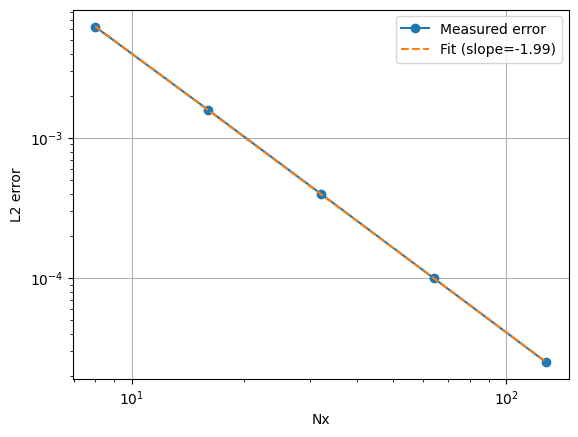

In [ ]:
grids = np.array([8, 16, 32, 64, 128])
errorsm1 = np.array([
    result['L2_error_method1'],
    result2['L2_error_method1'],
    result3['L2_error_method1'],
    result4['L2_error_method1'],
    result5['L2_error_method1']
])

# log–log data
logN = np.log(grids)
logE = np.log(errorsm1)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * grids**slope

# plot
plt.figure()
plt.loglog(grids, errorsm1, "o-", label="Measured error")
plt.loglog(grids, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.xlabel("Nx")
plt.ylabel("L2 error")
plt.legend()
plt.grid(True)
plt.savefig("p1.png",format="png",bbox_inches="tight",dpi=1000)
plt.show()

Observed convergence rate (slope): -1.99


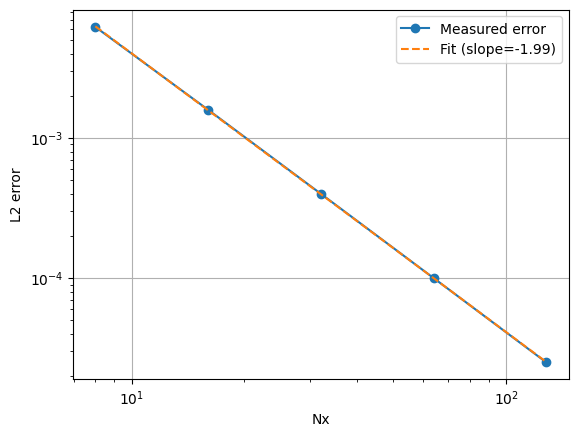

In [ ]:
grids = np.array([8, 16, 32, 64, 128])
errorsm2 = np.array([
    result['L2_error_method2'],
    result2['L2_error_method2'],
    result3['L2_error_method2'],
    result4['L2_error_method2'],
    result5['L2_error_method2']
])

# log–log data
logN = np.log(grids)
logE = np.log(errorsm2)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * grids**slope

# plot
plt.figure()
plt.loglog(grids, errorsm2, "o-", label="Measured error")
plt.loglog(grids, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.xlabel("Nx")
plt.ylabel("L2 error")
plt.legend()
plt.grid(True)
#plt.savefig("p1_method2.png",format="png",bbox_inches="tight",dpi=1000)
plt.show()

**CG2**

In [ ]:
resultp2 = solve_poisson_firedrake(nx=8, ny=8,degree=2)

print(f"Δx = {resultp2['mesh_size']}")
print(f"L2 error (Method 1): {resultp2['L2_error_method1']}")
print(f"L2 error (Method 2): {resultp2['L2_error_method2']}")
print(f"L2 difference: {resultp2['L2_difference']}")

#get_difference(resultp2,8,2)

Δx = 0.125
L2 error (Method 1): 1.657387395833284e-05
L2 error (Method 2): 1.6573873958762082e-05
L2 difference: 5.048249789984193e-16


In [ ]:
result2p2 = solve_poisson_firedrake(nx=16, ny=16,degree=2)

print(f"Δx = {result2p2['mesh_size']}")
print(f"L2 error (Method 1): {result2p2['L2_error_method1']}")
print(f"L2 error (Method 2): {result2p2['L2_error_method2']}")
print(f"L2 difference: {result2p2['L2_difference']}")

#get_difference(result2p2,16,2)

Δx = 0.0625
L2 error (Method 1): 1.042725203745395e-06
L2 error (Method 2): 1.042725250834068e-06
L2 difference: 6.279137729812737e-11


In [ ]:
result3p2 = solve_poisson_firedrake(nx=32, ny=32,degree=2)

print(f"Δx = {result3p2['mesh_size']}")
print(f"L2 error (Method 1): {result3p2['L2_error_method1']}")
print(f"L2 error (Method 2): {result3p2['L2_error_method2']}")
print(f"L2 difference: {result3p2['L2_difference']}")

#get_difference(result3p2,32,2)

Δx = 0.03125
L2 error (Method 1): 6.527731602099798e-08
L2 error (Method 2): 6.527728649518105e-08
L2 difference: 2.8485690870987836e-11


In [ ]:
result4p2 = solve_poisson_firedrake(nx=64, ny=64,degree=2)

print(f"Δx = {result4p2['mesh_size']}")
print(f"L2 error (Method 1): {result4p2['L2_error_method1']}")
print(f"L2 error (Method 2): {result4p2['L2_error_method2']}")
print(f"L2 difference: {result4p2['L2_difference']}")

#get_difference(result4p2,64,2)

Δx = 0.015625
L2 error (Method 1): 4.081580031002421e-09
L2 error (Method 2): 4.08155741956735e-09
L2 difference: 3.0393773349967527e-12


In [ ]:
result5p2 = solve_poisson_firedrake(nx=128, ny=128,degree=2)

print(f"Δx = {result5p2['mesh_size']}")
print(f"L2 error (Method 1): {result5p2['L2_error_method1']}")
print(f"L2 error (Method 2): {result5p2['L2_error_method2']}")
print(f"L2 difference: {result5p2['L2_difference']}")

#get_difference(result5p2,128,2)

Δx = 0.0078125
L2 error (Method 1): 2.554284505345017e-10
L2 error (Method 2): 2.553439877915786e-10
L2 difference: 2.4161630611936595e-12


Observed convergence rate (slope): -4.00


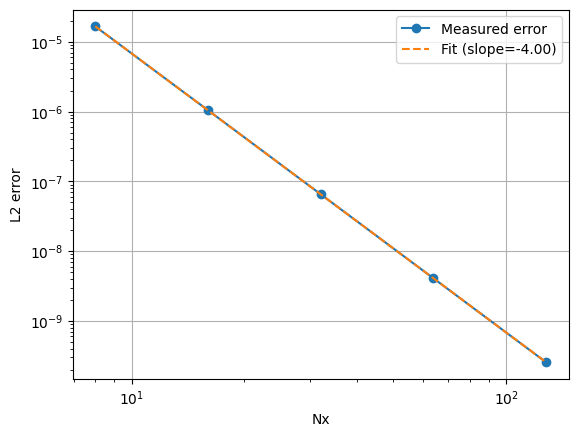

In [ ]:
grids = np.array([8, 16, 32, 64, 128])

errorsm2=[resultp2['L2_error_method1'],result2p2['L2_error_method1'],result3p2['L2_error_method1'],result4p2['L2_error_method1'],result5p2['L2_error_method1']]

# log–log data
logN = np.log(grids)
logE = np.log(errorsm2)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * grids**slope

# plot
plt.figure()
plt.loglog(grids, errorsm2, "o-", label="Measured error")
plt.loglog(grids, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.xlabel("Nx")
plt.ylabel("L2 error")
plt.legend()
plt.grid(True)
plt.savefig("p2.png",format="png",bbox_inches="tight",dpi=1000)

plt.show()

**CG3**

In [ ]:
resultp3 = solve_poisson_firedrake(nx=8, ny=8,degree=3)

print(f"Δx = {resultp3['mesh_size']}")
print(f"L2 error (Method 1): {resultp3['L2_error_method1']}")
print(f"L2 error (Method 2): {resultp3['L2_error_method2']}")
print(f"L2 difference: {resultp3['L2_difference']}")

#get_difference(resultp3,8,3)

Δx = 0.125
L2 error (Method 1): 1.0704333435587704e-07
L2 error (Method 2): 1.0702295304392314e-07
L2 difference: 1.9398837054793883e-10


In [ ]:
result2p3 = solve_poisson_firedrake(nx=16, ny=16,degree=3)

print(f"Δx = {result2p3['mesh_size']}")
print(f"L2 error (Method 1): {result2p3['L2_error_method1']}")
print(f"L2 error (Method 2): {result2p3['L2_error_method2']}")
print(f"L2 difference: {result2p3['L2_difference']}")

#get_difference(result2p3,16,3)

Δx = 0.0625
L2 error (Method 1): 3.382140333659924e-09
L2 error (Method 2): 3.378766091006887e-09
L2 difference: 3.0509996823079274e-11


In [ ]:
result3p3 = solve_poisson_firedrake(nx=32, ny=32,degree=3)

print(f"Δx = {result3p3['mesh_size']}")
print(f"L2 error (Method 1): {result3p3['L2_error_method1']}")
print(f"L2 error (Method 2): {result3p3['L2_error_method2']}")
print(f"L2 difference: {result3p3['L2_difference']}")

#get_difference(result3p3,32,3)

Δx = 0.03125
L2 error (Method 1): 1.0643879433091187e-10
L2 error (Method 2): 1.0585675715198992e-10
L2 difference: 1.1481543115488515e-11


In [ ]:
result4p3 = solve_poisson_firedrake(nx=64, ny=64,degree=3)

print(f"Δx = {result4p3['mesh_size']}")
print(f"L2 error (Method 1): {result4p3['L2_error_method1']}")
print(f"L2 error (Method 2): {result4p3['L2_error_method2']}")
print(f"L2 difference: {result4p3['L2_difference']}")

#get_difference(result4p3,64,3)

Δx = 0.015625
L2 error (Method 1): 5.347058769675166e-12
L2 error (Method 2): 3.361469232107901e-12
L2 difference: 4.246772127736674e-12


In [ ]:
result5p3 = solve_poisson_firedrake(nx=128, ny=128,degree=3)

print(f"Δx = {result5p3['mesh_size']}")
print(f"L2 error (Method 1): {result5p3['L2_error_method1']}")
print(f"L2 error (Method 2): {result5p3['L2_error_method2']}")
print(f"L2 difference: {result5p3['L2_difference']}")

#get_difference(result5p3,128,3)

Δx = 0.0078125
L2 error (Method 1): 2.1966010972514424e-12
L2 error (Method 2): 2.6697396957114204e-12
L2 difference: 1.338411128333788e-12


Observed convergence rate (slope): -4.05


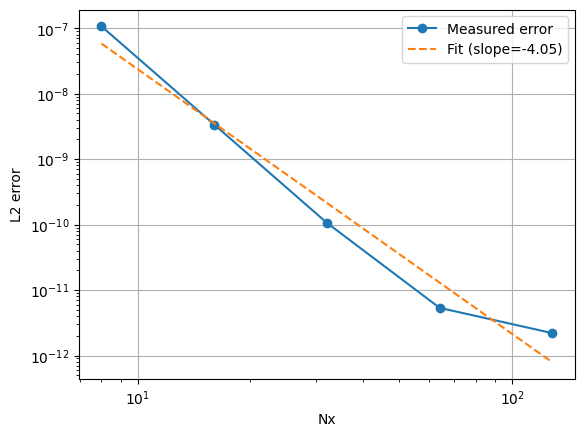

In [ ]:
grids = np.array([8, 16, 32, 64, 128])

errorsm3=[resultp3['L2_error_method1'],result2p3['L2_error_method1'],result3p3['L2_error_method1'],result4p3['L2_error_method1'],result5p3['L2_error_method1'],

          ]

# log–log data
logN = np.log(grids)
logE = np.log(errorsm3)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * grids**slope

# plot
plt.figure()
plt.loglog(grids, errorsm3, "o-", label="Measured error")
plt.loglog(grids, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.xlabel("Nx")
plt.ylabel("L2 error")
plt.legend()
plt.grid(True)
#plt.savefig("p3.png",format="png",bbox_inches="tight",dpi=1000)

plt.show()

In [ ]:
def get_difference2(res,grid,order,CG="CG1"):
  mesh=res["u_sol"].function_space().mesh()
  x,y = SpatialCoordinate(mesh)
  V = res['u_sol'].function_space()

  u_exact = Function(V, name="u_exact")
  center_dist = (x - 0.5)**2 + (y - 0.5)**2
  u_exact_expr = exp(-100 * center_dist)
  u_exact.interpolate(u_exact_expr)

  diff1=Function(V, name="error")
  diff1.interpolate(abs(res['u_sol']-u_exact))

  outfile = VTKFile(f"outputdiff_{grid}_{order}.pvd")
  outfile.write(res['u_sol'],u_exact,diff1)

<Figure size 800x600 with 0 Axes>

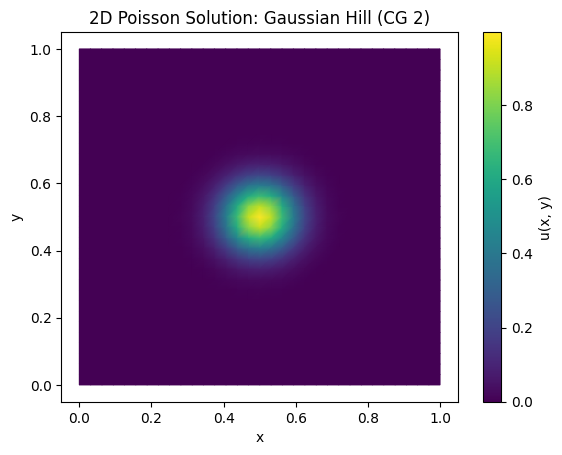

Mesh resolution: Δx = 0.0625
L2 error: 0.00030039516852498017


<Figure size 800x600 with 0 Axes>

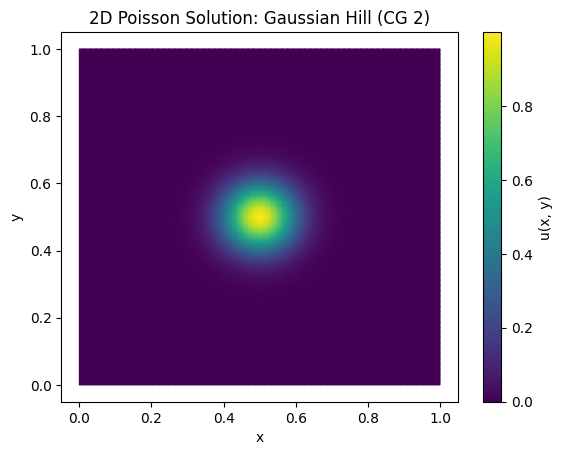

Mesh resolution: Δx = 0.03125
L2 error: 2.1183802287497694e-05


<Figure size 800x600 with 0 Axes>

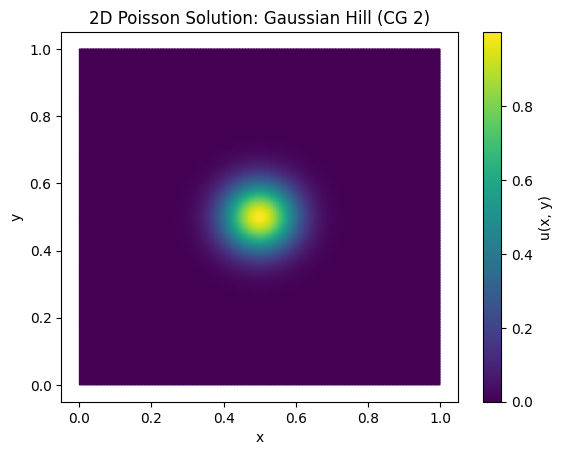

Mesh resolution: Δx = 0.015625
L2 error: 1.37388799812676e-06


<Figure size 800x600 with 0 Axes>

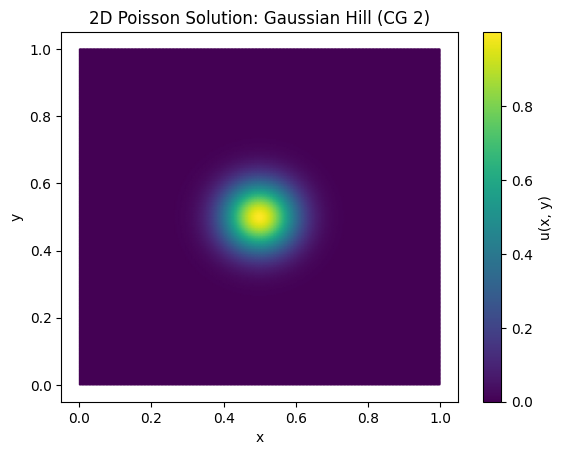

Mesh resolution: Δx = 0.0078125
L2 error: 8.716915465279913e-08


<Figure size 800x600 with 0 Axes>

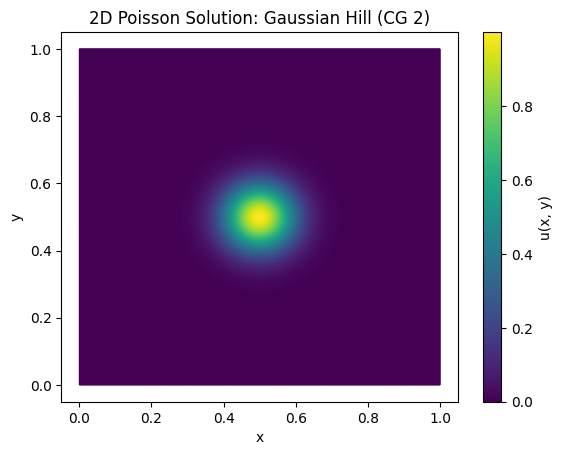

Mesh resolution: Δx = 0.00390625
L2 error: 6.4117577796236955e-09


In [12]:
from firedrake import *
import matplotlib.pyplot as plt

def get_difference2(u_sol, grid, order, CG="CG1"):
    # u_sol is already the function, no need to index it like a dict
    mesh = u_sol.function_space().mesh()
    x, y = SpatialCoordinate(mesh)
    V = u_sol.function_space()

    u_exact = Function(V, name="u_exact")
    center_dist = (x - 0.5)**2 + (y - 0.5)**2
    u_exact_expr = exp(-100 * center_dist)
    u_exact.interpolate(u_exact_expr)

    diff1 = Function(V, name="error")
    # Use u_sol directly here
    diff1.interpolate(abs(u_sol - u_exact))

    outfile = VTKFile(f"outputdiff_{grid}_{order}.pvd")
    outfile.write(u_sol, u_exact, diff1)




def solve_poisson(n_res,degree=1,save_data=False):
    mesh = UnitSquareMesh(n_res, n_res, quadrilateral=True)
    V = FunctionSpace(mesh, 'CG', degree)

    x, y = SpatialCoordinate(mesh)

    # --- Step 6: Define new exact solution and source f ---
    # Using a Gaussian Hill: u = exp(-100 * ((x-0.5)**2 + (y-0.5)**2))
    # This creates a "tiny curved area" in the center of the domain.
    center_dist = (x - 0.5)**2 + (y - 0.5)**2
    u_exact_expr = exp(-100 * center_dist)

    # f = -div(grad(u)). For this Gaussian, f is derived via calculus:
    f_expr = 400 * (1 - 100 * center_dist) * exp(-100 * center_dist)

    f = Function(V).interpolate(f_expr)
    u_sol = Function(V, name="Solution")
    v = TestFunction(V)
    u_trial = TrialFunction(V)

    # --- Variational Form ---
    a = inner(grad(u_trial), grad(v)) * dx
    L = f * v * dx

    # --- Boundary Conditions ---
    # Setting Dirichlet on all boundaries (1, 2, 3, 4) based on exact solution
    bc = DirichletBC(V, u_exact_expr, "on_boundary")

    # Solve
    solve(a == L, u_sol, bcs=bc,
          solver_parameters={'ksp_type': 'cg', 'pc_type': 'ilu'})

    # --- Error Analysis ---
    u_exact_fn = Function(V).interpolate(u_exact_expr)
    l2_error = errornorm(u_exact_fn, u_sol, 'L2')

    if save_data:
      outfile = VTKFile(f'Q6output_{n_res}_{degree}.pvd')
      outfile.write(u_sol)

    return n_res, l2_error, u_sol


nres=[16,32,64,128,256]

errors=[]

for i in nres:
    res, l2_error,u_sol = solve_poisson(i,degree=2,save_data=True)
    plt.figure(figsize=(8, 6))
    contours = tripcolor(u_sol)
    plt.colorbar(contours, label='u(x, y)')
    plt.title("2D Poisson Solution: Gaussian Hill (CG 2)")
    plt.xlabel("x")
    plt.ylabel("y")
    if i==128:
      plt.savefig("newanalytical.png",format="png",bbox_inches="tight",dpi=1000)
    plt.show()
    get_difference2(u_sol,i,2)
    print(f'Mesh resolution: Δx = {1/res}')
    print(f'L2 error: {l2_error}')
    errors.append(l2_error)



Observed convergence rate (slope): -3.90


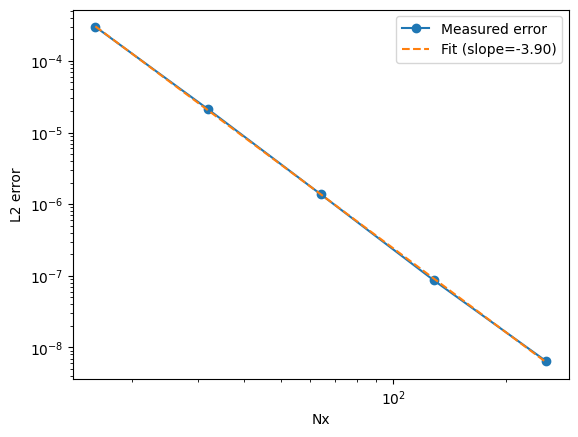

In [14]:

# log–log data
logN = np.log(nres)
logE = np.log(errors)

# linear fit in log–log space
slope, intercept = np.polyfit(logN, logE, 1)

print(f"Observed convergence rate (slope): {slope:.2f}")

# fitted line
fit_errors = np.exp(intercept) * nres**slope

# plot
plt.figure()
plt.loglog(nres, errors, "o-", label="Measured error")
plt.loglog(nres, fit_errors, "--", label=f"Fit (slope={slope:.2f})")
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Nx')
plt.ylabel('L2 error')
plt.legend()
plt.savefig("Analyticalresidual.png",format="png",bbox_inches="tight",dpi=1000)
plt.show()

128